# Predictive Modeling for Multi-Labels Tagging  in Algorithmic Challenges

In [3]:
# ! pip install spacy
# ! pip install seaborn
# ! pip install nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score, precision_recall_fscore_support as score, multilabel_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tabulate import tabulate
import re
import warnings
warnings.filterwarnings('ignore')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

## Data Loading and Preprocessing

In [2]:
df = pd.read_csv('codeforces.csv')
df.head()

,contest,problem_name,problem_statement,problem_tags
0,325,A,You are given n rectangles. The corners of rec...,"implementation,*1500"
1,325,B,Daniel is organizing a football tournament. He...,"binarysearch,math,*1800"
2,325,C,Piegirl has found a monster and a book about m...,"dfsandsimilar,graphs,shortestpaths,*2600"
3,325,D,"In a far away land, there exists a planet shap...","dsu,*2900"
4,325,E,Piegirl found the red button. You have one las...,"combinatorics,dfsandsimilar,dsu,graphs,greedy,..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8343 entries, 0 to 8342
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   contest            8343 non-null   int64 
 1   problem_name       8343 non-null   object
 2   problem_statement  8336 non-null   object
 3   problem_tags       8279 non-null   object
dtypes: int64(1), object(3)
memory usage: 260.8+ KB


In [4]:
#checking for nulls
df.isnull().sum()

contest               0
problem_name          0
problem_statement     7
problem_tags         64
dtype: int64

In [5]:
#droping the null values 
df = df.dropna()
df.isnull().sum()

contest              0
problem_name         0
problem_statement    0
problem_tags         0
dtype: int64

In [6]:
#splitting difficulty rating and problem tags
df['problem_difficulty']=df['problem_tags'].str.split(',').str[-1].apply(lambda x:str(x)[1:])
df['tags']=df['problem_tags'].str.split(',').str[:-1]   
df = df.drop(columns=['problem_tags'])
df.head()

,contest,problem_name,problem_statement,problem_difficulty,tags
0,325,A,You are given n rectangles. The corners of rec...,1500,[implementation]
1,325,B,Daniel is organizing a football tournament. He...,1800,"[binarysearch, math]"
2,325,C,Piegirl has found a monster and a book about m...,2600,"[dfsandsimilar, graphs, shortestpaths]"
3,325,D,"In a far away land, there exists a planet shap...",2900,[dsu]
4,325,E,Piegirl found the red button. You have one las...,2800,"[combinatorics, dfsandsimilar, dsu, graphs, gr..."


In [7]:
print(df['problem_statement'].duplicated().any())

True


In [8]:
duplicate_rows = df[df.duplicated(subset=['problem_statement'], keep=False)]
sorted_duplicate_rows = duplicate_rows.sort_values(by='problem_statement')
print(sorted_duplicate_rows.head())

      contest problem_name                                  problem_statement  \
4495      896            A  \n\nNephren is playing a game with little lepr...   
4502      897            C  \n\nNephren is playing a game with little lepr...   
5092     1341            F   Denis came to Nastya and discovered that she ...   
5084     1340            D   Denis came to Nastya and discovered that she ...   
5081     1340            A   Denis was very sad after Nastya rejected him....   

     problem_difficulty                                               tags  
4495               1700                      [binarysearch, dfsandsimilar]  
4502               1700                [binarysearch, combinatorics, math]  
5092               2600    [constructivealgorithms, dfsandsimilar, graphs]  
5084               2600  [constructivealgorithms, dfsandsimilar, graphs...  
5081               1500  [bruteforce, datastructures, greedy, implement...  


As we can see, duplicate questions have different tags, we will merge the tag list and remove duplicates

In [9]:
agg_dict = {
    'tags': 'sum',  # concatenate lists of tags
    'contest': 'first',  # keep the first value for other columns
    'problem_name': 'first',
    'problem_difficulty': 'first'
}
merged_df = df.groupby('problem_statement').agg(agg_dict).reset_index()
df = merged_df.drop_duplicates(subset='problem_statement')
df.reset_index(drop=True, inplace=True)
df.head()

,problem_statement,tags,contest,problem_name,problem_difficulty
0,\n\nNephren is playing a game with little lepr...,"[binarysearch, dfsandsimilar, binarysearch, co...",896,A,1700
1,\n\nThe input contains a single integer a (0 ...,[*specialproblem],656,D,2100
2,Denis came to Nastya and discovered that she ...,"[constructivealgorithms, dfsandsimilar, graphs...",1340,D,2600
3,Denis was very sad after Nastya rejected him....,"[bruteforce, datastructures, greedy, implement...",1340,A,1500
4,"Denis, after buying flowers and sweets (you w...","[bitmasks, dp, graphs, greedy, bitmasks, dp, g...",1340,B,1700


### Cleaning the problem statement

In [10]:
df_processed = df.copy()

# Replaceing all '\n' in the problem statement and convert to lowercase
problem_stat_processed = df_processed['problem_statement'].replace(r'\n', ' ', regex=True).str.lower()

# Removing unicodes
problem_stat_processed = [re.sub('\s[\$\s]+\w*[\$\s]+', '', item.encode('ascii', 'ignore').decode('ascii')) for item in problem_stat_processed]

# Removing HTML tags
CLEANR = re.compile('<.*?>')
problem_stat_processed = [re.sub(CLEANR, ' ', str(item)) for item in problem_stat_processed]

# Removing stop words
problem_stat_processed = [" ".join([word for word in word_tokenize(sentence) if word not in STOP_WORDS]) for sentence in problem_stat_processed]
print(problem_stat_processed[69])

boy named gena wants `` russian code cup '' finals , t-shirt . offered problems complex , arrangement n friends solve problems him.participants offered m problems contest . friend , gena knows problems solve . gena friends wo agree help gena : i-th friend asks gena xi rubles help solving problems . , friend agreed write code gena gena computer connected ki monitors , monitor costs b rubles.is careful money , wants spend little money possible solve problems . help gena , tell spend smallest possible money . initially , monitors connected gena computer.first line contains integers n , m b ( 1n100 ; 1m20 ; 1b109 ) number gena friends , number problems cost single monitor.following 2n lines describe friends . lines number 2i ( 2i+1 ) contain information i-th friend . 2i-th line contains integers xi , ki mi ( 1xi109 ; 1ki109 ; 1mim ) desired money , monitors number problems friend solve . ( 2i+1 ) -th line contains mi distinct positive integers numbers problems i-th friend solve . problems 

## Exploratory Data Analysis

In [11]:
#Calculate number of problem tags in the dataset
tags_dict = {}
for allTags in df_processed["tags"]:
    for tag in allTags :
        if tag not in tags_dict:
            tags_dict[tag] = 0 
        tags_dict[tag] += 1 

tags_dict_sorted = dict(sorted(tags_dict.items(), key = lambda x: x[1], reverse = True))
tag_count = {"Tag":list(tags_dict_sorted.keys()), "Count": list(tags_dict_sorted.values())}
count_df = pd.DataFrame(data = tag_count)
count_df[:10]

,Tag,Count
0,implementation,2199
1,math,1989
2,greedy,1943
3,dp,1668
4,datastructures,1284
5,constructivealgorithms,1176
6,bruteforce,1168
7,graphs,893
8,binarysearch,785
9,sortings,750


In [12]:
df.head()

,problem_statement,tags,contest,problem_name,problem_difficulty
0,\n\nNephren is playing a game with little lepr...,"[binarysearch, dfsandsimilar, binarysearch, co...",896,A,1700
1,\n\nThe input contains a single integer a (0 ...,[*specialproblem],656,D,2100
2,Denis came to Nastya and discovered that she ...,"[constructivealgorithms, dfsandsimilar, graphs...",1340,D,2600
3,Denis was very sad after Nastya rejected him....,"[bruteforce, datastructures, greedy, implement...",1340,A,1500
4,"Denis, after buying flowers and sweets (you w...","[bitmasks, dp, graphs, greedy, bitmasks, dp, g...",1340,B,1700


In [13]:
tags_dict = {}
for allTags in df_processed["tags"]:
    for tag in allTags :
        if tag not in tags_dict:
            tags_dict[tag] = 0 
        tags_dict[tag] += 1 

tags_dict_sorted = dict(sorted(tags_dict.items(), key = lambda x: x[1], reverse = True))
tag_count = {"Tag":list(tags_dict_sorted.keys()), "Count": list(tags_dict_sorted.values())}
count_df = pd.DataFrame(data = tag_count)
total_tags=count_df.Tag

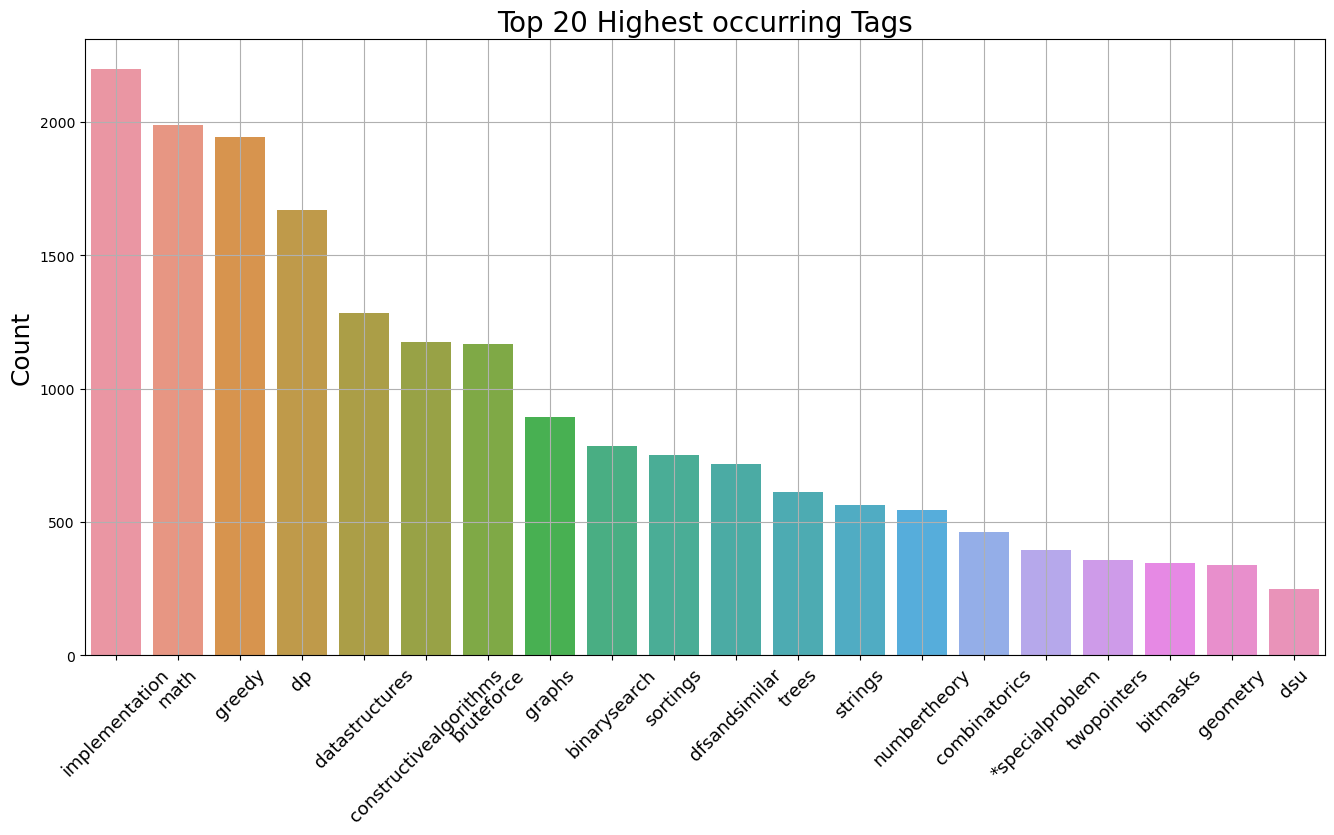

In [14]:
count_df = count_df.head(20)  # Selecting the top 20 rows for plotting

# Creating the bar plot using seaborn
plt.figure(figsize=(16, 8))
sns.barplot(x='Tag', y='Count', data=count_df)

# Setting up the labels and title
plt.xlabel("", fontsize=13)
plt.ylabel("Count", fontsize=18)
plt.title("Top 20 Highest occurring Tags", fontsize=20)
plt.xticks(rotation=45, fontsize=13)  # Rotate x labels for better readability
plt.grid(True)

plt.show()

implementation and maths tags are most frequent

In [15]:
df_processed["tags"] = df_processed["tags"].apply(lambda x:" ".join(x))
df_processed.isnull().sum()

problem_statement     0
tags                  0
contest               0
problem_name          0
problem_difficulty    0
dtype: int64

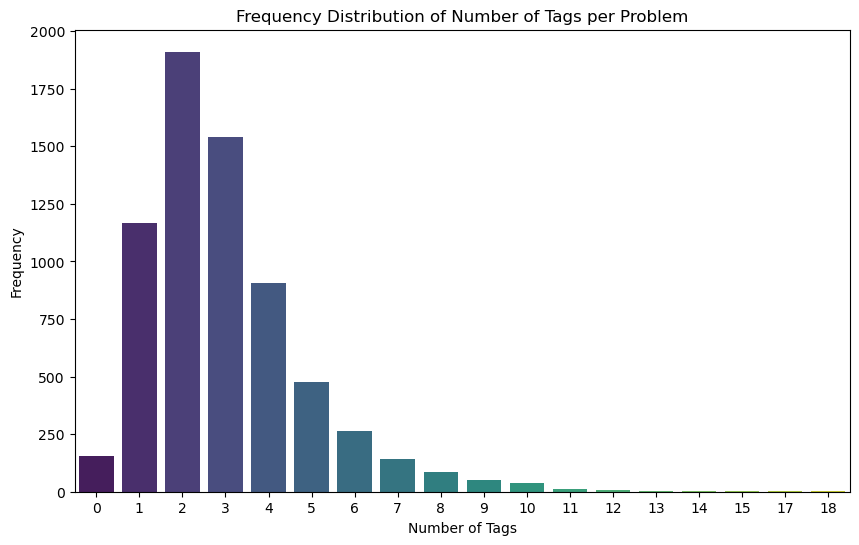

In [16]:
df_processed['num_tags'] = df_processed['tags'].apply(lambda x: len(x.split()))

num_tags_distribution = df_processed['num_tags'].value_counts()

color_palette = sns.color_palette("viridis", len(num_tags_distribution))
plt.figure(figsize=(10, 6))
sns.countplot(x='num_tags', data=df_processed, palette=color_palette)
plt.title('Frequency Distribution of Number of Tags per Problem')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.show()

In [17]:
columns_to_drop = ['num_tags']
df_processed = df_processed.drop(columns=columns_to_drop)

From the above we can conclude that null values are removed from the dataframe.

In [18]:
df2=df_processed.groupby(df_processed.columns.tolist(),as_index=False).size()

In [19]:
df2

,problem_statement,tags,contest,problem_name,problem_difficulty,size
0,\n\nNephren is playing a game with little lepr...,binarysearch dfsandsimilar binarysearch combin...,896,A,1700,1
1,\n\nThe input contains a single integer a (0 ...,*specialproblem,656,D,2100,1
2,Denis came to Nastya and discovered that she ...,constructivealgorithms dfsandsimilar graphs tr...,1340,D,2600,1
3,Denis was very sad after Nastya rejected him....,bruteforce datastructures greedy implementatio...,1340,A,1500,1
4,"Denis, after buying flowers and sweets (you w...",bitmasks dp graphs greedy bitmasks dp greedy,1340,B,1700,1
...,...,...,...,...,...,...
6761,— I experienced so many great things.\n\n— You...,bruteforce,897,B,1300,1
6762,"— I... I survived.\n\n— Welcome home, Chtholly...",datastructures dsu,896,E,3100,1
6763,— That'll do it. \n\nBThero is a powerful magi...,greedy math,1417,A,800,1
6764,— This is not playing but duty as allies of ju...,combinatorics dp math,869,C,1800,1


In [20]:
df2.groupby('size').count()

,problem_statement,tags,contest,problem_name,problem_difficulty
size,,,,,
1,6766,6766,6766,6766,6766


No Duplicate data points that is denoted by the value in 1.

In [21]:
df_processed['tags_count'] = [len(i.split(" ")) for i in df_processed["tags"]]
df_processed.head()

,problem_statement,tags,contest,problem_name,problem_difficulty,tags_count
0,\n\nNephren is playing a game with little lepr...,binarysearch dfsandsimilar binarysearch combin...,896,A,1700,5
1,\n\nThe input contains a single integer a (0 ...,*specialproblem,656,D,2100,1
2,Denis came to Nastya and discovered that she ...,constructivealgorithms dfsandsimilar graphs tr...,1340,D,2600,7
3,Denis was very sad after Nastya rejected him....,bruteforce datastructures greedy implementatio...,1340,A,1500,6
4,"Denis, after buying flowers and sweets (you w...",bitmasks dp graphs greedy bitmasks dp greedy,1340,B,1700,7


In [22]:
min_tag_count = df_processed["tags_count"].min()
max_tag_count = df_processed["tags_count"].max()
avg_tag_count = df_processed["tags_count"].mean()
meadian_tag_count = df_processed["tags_count"].median()

print("Maximum tags per question:" + str(max_tag_count))
print("Minimum tags per question:" + str(min_tag_count))
print("Mean tags per question:" + str(avg_tag_count))
print("Median tags per question:" + str(meadian_tag_count))

Maximum tags per question:18
Minimum tags per question:1
Mean tags per question:2.9915755246822346
Median tags per question:3.0


In [23]:
df_processed['tags_count'].value_counts()

2     1911
3     1539
1     1323
4      906
5      476
6      265
7      142
8       87
9       52
10      36
11      10
12       9
14       3
13       3
18       2
17       1
15       1
Name: tags_count, dtype: int64

- Maximum number of tags per question: 18
- Minimum number of tags per question: 1
- Avg. number of tags per question: 2.991
- Most of the questions are having 2 or 3 tags

In [24]:
tag_word_count=[len(list(tags_dict_sorted.keys())[list(tags_dict_sorted.keys()).index(index)]) for index in list(tags_dict_sorted.keys())]
tags=list(tags_dict_sorted.keys())

Text(0, 0.5, 'Count of words in the Tags')

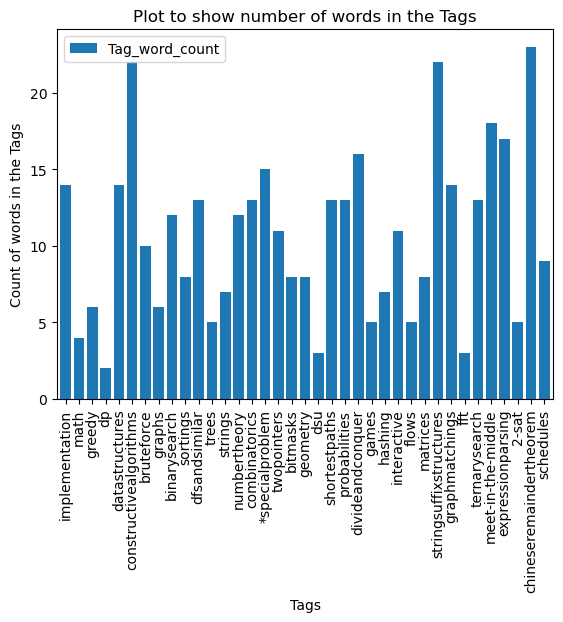

In [25]:
d = {'Tag_word_count': tag_word_count, 'Tags': tags}
df_tag_word_count = pd.DataFrame(data=d)
df_tag_word_count

plot_tags=df_tag_word_count.plot(kind="bar",x='Tags', width=0.8)
plt.title('Plot to show number of words in the Tags')
plt.xlabel('Tags')
plt.ylabel('Count of words in the Tags')

In [26]:
count_multigrams=0
count_datapoints=0

tag_value_list=df_processed.tags

for i in tag_value_list:
    for j, x in enumerate(i.split()):
        a=i.split()
        count_datapoints+=1
        if(len(a)>1):
            count_multigrams+=1
print("Total tokenized words:",count_datapoints)
print("Number of unigrams in the dataset are:",count_datapoints-count_multigrams)
print("Number of Multigrams in the dataset are:",count_multigrams)

Total tokenized words: 20087
Number of unigrams in the dataset are: 1169
Number of Multigrams in the dataset are: 18918


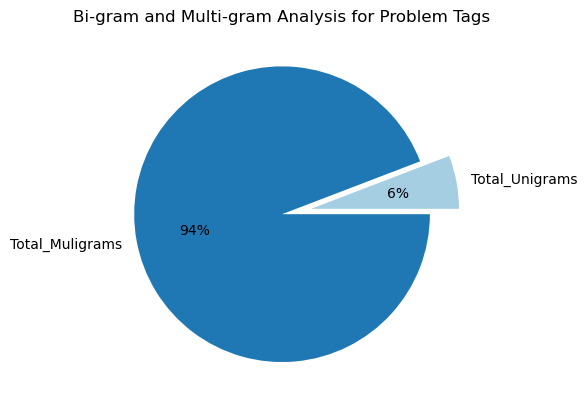

In [27]:
data = [count_datapoints-count_multigrams,count_multigrams]
labels = ['Total_Unigrams', 'Total_Muligrams']

my_explode=[0.2,0]
colors = sns.color_palette('Paired')
         
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%',explode=my_explode)
plt.title('Bi-gram and Multi-gram Analysis for Problem Tags')
plt.show()

## Model Fitting

In [28]:
def process_data(problem_stat_processed, df):
    # Tokenize and remove stop words
    problem_stat_processed = [" ".join([word for word in word_tokenize(sentence) if word not in STOP_WORDS]) for sentence in problem_stat_processed]

    # Lemmatization
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    problem_stat_processed = [" ".join([lemmatizer.lemmatize(word) for word in word_tokenize(sentence)]) for sentence in problem_stat_processed]

    # Stemming
    ps = PorterStemmer()
    problem_stat_processed = [" ".join([ps.stem(word) for word in word_tokenize(sentence)]) for sentence in problem_stat_processed]
    
    df.problem_statement=problem_stat_processed
    
    df["tags"] = df["tags"].apply(lambda x:" ".join(x))
    vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
    multi_tags = vectorizer.fit_transform(df.tags)
    
    #removing any non-ASCII characters and a specific pattern of whitespace, dollar signs, and word characters using regular expressions. 
    def clean_data(row):
        return re.sub('\s[\$\s]+\w*[\$\s]+', '', row.encode('ascii', 'ignore').decode('ascii'))

    df['problem_statement'] = df['problem_statement'].apply(clean_data)
     
    return df

In [29]:
df = process_data(problem_stat_processed, df)

In [30]:
X = df[['problem_statement']]
y = df[["tags"]]

#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5412, 1), (1354, 1), (5412, 1), (1354, 1))

In [31]:
#Vectorizing the Inputs.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
x_train_multilabel = vectorizer.fit_transform(X_train['problem_statement'])
x_test_multilabel = vectorizer.transform(X_test['problem_statement'])

y_train = vectorizer.fit_transform(y_train['tags'])
y_test = vectorizer.fit_transform(y_test['tags'])

In [32]:
print(y_train[0])

  (0, 6)	1
  (0, 9)	1
  (0, 22)	1
  (0, 24)	1
  (0, 35)	1


In [33]:
print("Train data diemnsions are :",x_train_multilabel.shape, "Y :",y_train.shape)
print("Test data dimensions are :",x_test_multilabel.shape,"Y:",y_test.shape)

Train data diemnsions are : (5412, 54989) Y : (5412, 37)
Test data dimensions are : (1354, 54989) Y: (1354, 37)


#### LogisticRegression for multi-label classification.


In [34]:
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l2',solver='sag', max_iter=1000))
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)

print("Accuracy of the Logistic Regression is:",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss of the Logistic Regression is",metrics.hamming_loss(y_test,predictions_2))

precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average scores")
print("Precision are : {:.4f}, Recall are : {:.4f}, F1-measure are : {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average scores")
print("Precision are : {:.4f}, Recall are: {:.4f}, F1-measure are: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))

Accuracy of the Logistic Regression is: 0.07459379615952733
Hamming loss of the Logistic Regression is 0.06792686334783823
Micro-average scores
Precision are : 0.5363, Recall are : 0.2916, F1-measure are : 0.3778
Macro-average scores
Precision are : 0.4194, Recall are: 0.2126, F1-measure are: 0.2614
              precision    recall  f1-score   support

           0       0.73      0.24      0.36        68
           1       0.00      0.00      0.00         5
           2       0.39      0.08      0.13       148
           3       0.42      0.10      0.16        50
           4       0.27      0.09      0.14       210
           5       0.00      0.00      0.00         1
           6       0.55      0.25      0.35        71
           7       0.45      0.26      0.33       211
           8       0.54      0.31      0.40       213
           9       0.53      0.30      0.38       137
          10       0.00      0.00      0.00        46
          11       0.39      0.22      0.28       

In [35]:
param_grid = dict(estimator__C=[1, 1.2], estimator__penalty = ['l1', 'l2'], estimator__solver = ['liblinear', 'sag'])
gsv = GridSearchCV(OneVsRestClassifier(LogisticRegression(class_weight='balanced')), param_grid=param_grid, verbose=5, n_jobs=-1)
gsv.fit(x_train_multilabel, y_train)

print('Hyper parameters are  ', gsv.best_params_)
print('Best Score values are ', gsv.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Hyper parameters are   {'estimator__C': 1, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
Best Score values are  0.060606277830972013


In [36]:
classifier = OneVsRestClassifier(LogisticRegression(C=1.2, solver='liblinear', penalty='l2'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

print("Accuracy after hyper-parameter tuning is :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss after hyper-parameter tuning ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average score after tuning")
print("Precision are: {:.4f}, Recall are: {:.4f}, F1-measure are: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average score after tuning")
print("Precision are: {:.4f}, Recall are: {:.4f}, F1-measure  are: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))

Accuracy after hyper-parameter tuning is : 0.0775480059084195
Hamming loss after hyper-parameter tuning  0.06788694159447482
Micro-average score after tuning
Precision are: 0.5364, Recall are: 0.2949, F1-measure are: 0.3806
Macro-average score after tuning
Precision are: 0.4327, Recall are: 0.2183, F1-measure  are: 0.2670
              precision    recall  f1-score   support

           0       0.74      0.25      0.37        68
           1       0.00      0.00      0.00         5
           2       0.41      0.09      0.14       148
           3       0.40      0.12      0.18        50
           4       0.26      0.09      0.13       210
           5       0.00      0.00      0.00         1
           6       0.50      0.21      0.30        71
           7       0.45      0.26      0.33       211
           8       0.55      0.33      0.41       213
           9       0.51      0.29      0.37       137
          10       0.50      0.02      0.04        46
          11       0.38    

In [37]:
#Printing multi-label confusion matrix .
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CM-" + class_label)

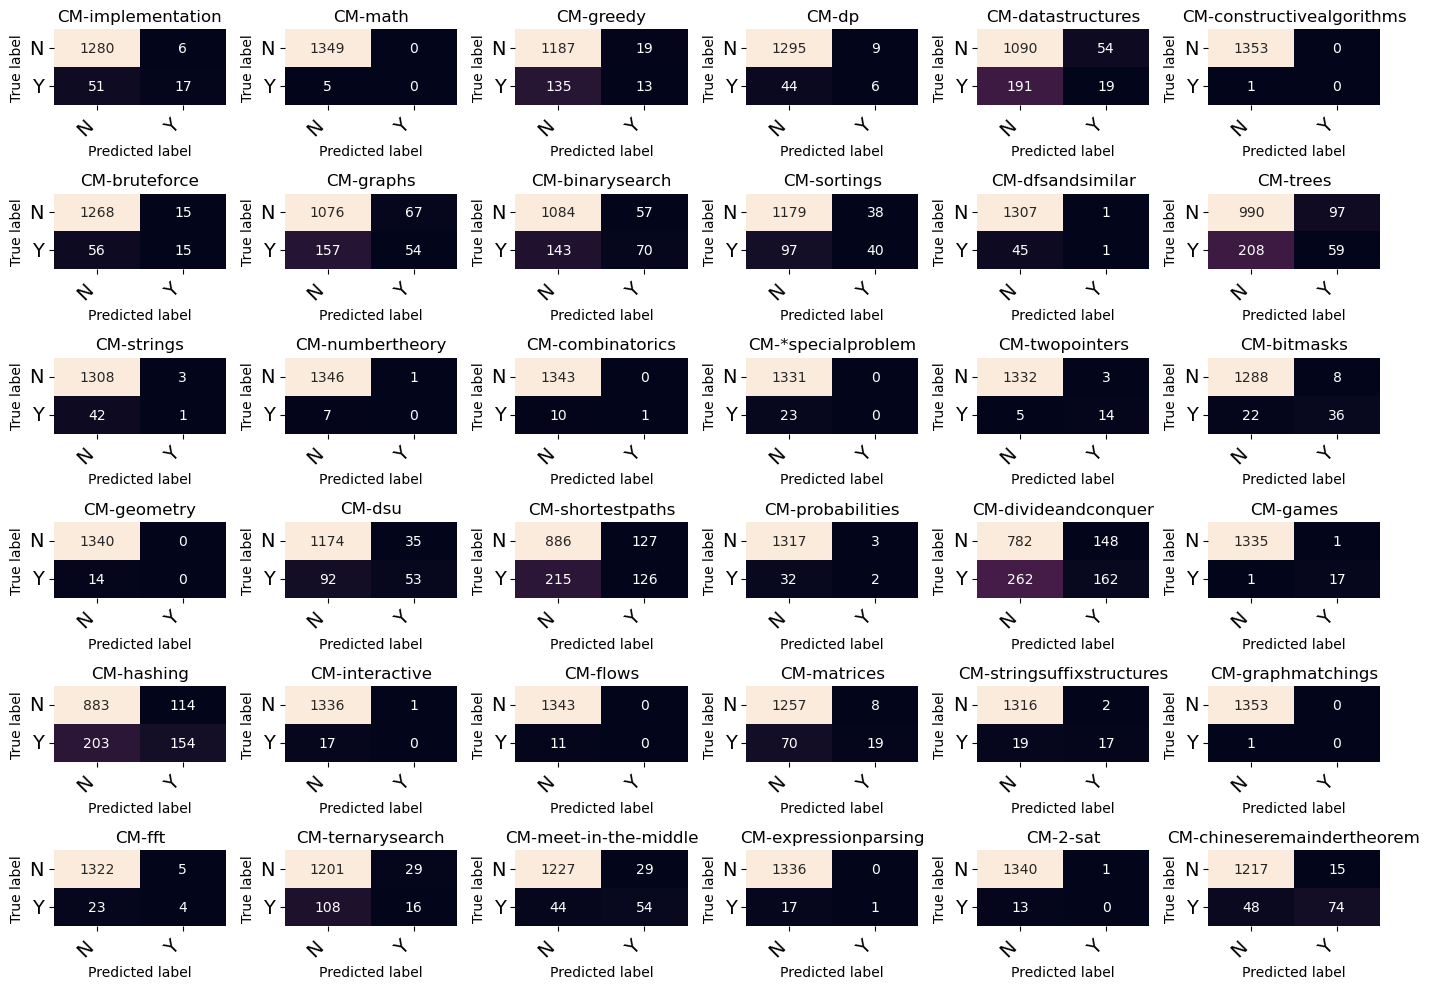

In [38]:
labels=total_tags.astype(str).values.tolist()
cfs_matrix=multilabel_confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(6, 6, figsize=(14, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), cfs_matrix, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"]) 
fig.tight_layout()
plt.show()

#### Linear SVM (SGD with hinge loss)


In [39]:
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions_sdg = classifier.predict(x_test_multilabel)

print("Accuracy of the SVM Classifier is:",metrics.accuracy_score(y_test, predictions_sdg))
print("Hamming loss of the SVM Classifier is",metrics.hamming_loss(y_test, predictions_sdg))

precision = precision_score(y_test, predictions_sdg, average='micro')
recall = recall_score(y_test, predictions_sdg, average='micro')
f1 = f1_score(y_test, predictions_sdg, average='micro')
 
print("Micro-average scores")
print("Precision are : {:.4f}, Recall are : {:.4f}, F1-measure are : {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_sdg, average='macro')
recall = recall_score(y_test, predictions_sdg, average='macro')
f1 = f1_score(y_test, predictions_sdg, average='macro')
 
print("Macro-average scores")
print("Precision are : {:.4f}, Recall are: {:.4f}, F1-measure are: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_sdg))

Accuracy of the SVM Classifier is: 0.056129985228951254
Hamming loss of the SVM Classifier is 0.07780749730528165
Micro-average scores
Precision are : 0.4352, Recall are : 0.3367, F1-measure are : 0.3797
Macro-average scores
Precision are : 0.3370, Recall are: 0.2473, F1-measure are: 0.2760
              precision    recall  f1-score   support

           0       0.47      0.26      0.34        68
           1       0.00      0.00      0.00         5
           2       0.28      0.11      0.16       148
           3       0.18      0.12      0.14        50
           4       0.24      0.19      0.21       210
           5       0.00      0.00      0.00         1
           6       0.34      0.21      0.26        71
           7       0.42      0.32      0.37       211
           8       0.44      0.36      0.39       213
           9       0.39      0.34      0.36       137
          10       0.08      0.02      0.03        46
          11       0.32      0.26      0.29       267
     

In [40]:
# Hyper paramter tuning for best accuracy.
param_grid = dict(estimator__alpha=[0.001, 0.01], estimator__penalty=['l1', 'l2', 'elasticnet'])
gsv = GridSearchCV(OneVsRestClassifier(SGDClassifier()), param_grid=param_grid, verbose=5, n_jobs=-1)
gsv.fit(x_train_multilabel, y_train)

print('Hyper parameters are  ', gsv.best_params_)
print('Best Score values are ', gsv.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Hyper parameters are   {'estimator__alpha': 0.01, 'estimator__penalty': 'l2'}
Best Score values are  0.07686818466537976


In [41]:
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.001, penalty='l2'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions_sdg = classifier.predict(x_test_multilabel)

print("Accuracy of the SVM Classifier is:",metrics.accuracy_score(y_test, predictions_sdg))
print("Hamming loss of the SVM Classifier is",metrics.hamming_loss(y_test, predictions_sdg))

precision = precision_score(y_test, predictions_sdg, average='micro')
recall = recall_score(y_test, predictions_sdg, average='micro')
f1 = f1_score(y_test, predictions_sdg, average='micro')
 
print("Micro-average scores")
print("Precision are : {:.4f}, Recall are : {:.4f}, F1-measure are : {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_sdg, average='macro')
recall = recall_score(y_test, predictions_sdg, average='macro')
f1 = f1_score(y_test, predictions_sdg, average='macro')
 
print("Macro-average scores")
print("Precision are : {:.4f}, Recall are: {:.4f}, F1-measure are: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_sdg))

Accuracy of the SVM Classifier is: 0.06868537666174299
Hamming loss of the SVM Classifier is 0.07377540021557746
Micro-average scores
Precision are : 0.4689, Recall are : 0.3251, F1-measure are : 0.3840
Macro-average scores
Precision are : 0.3782, Recall are: 0.2308, F1-measure are: 0.2713
              precision    recall  f1-score   support

           0       0.56      0.35      0.43        68
           1       0.00      0.00      0.00         5
           2       0.33      0.10      0.15       148
           3       0.38      0.10      0.16        50
           4       0.25      0.14      0.18       210
           5       0.00      0.00      0.00         1
           6       0.49      0.27      0.35        71
           7       0.39      0.27      0.32       211
           8       0.45      0.41      0.43       213
           9       0.54      0.25      0.34       137
          10       0.20      0.02      0.04        46
          11       0.33      0.27      0.29       267
      

In [42]:
rfc_classifier = RandomForestClassifier()

#Random forest classifier model
rfc_clf = OneVsRestClassifier(rfc_classifier)
rfc_clf.fit(x_train_multilabel, y_train)

rfc_predictions = rfc_clf.predict(x_test_multilabel)

print("Accuracy of the Random forest Classifier is:",metrics.accuracy_score(y_test, rfc_predictions))
rf_hamming_loss=metrics.hamming_loss(y_test, rfc_predictions)
print("Hamming loss of the Random forest Classifier is",rf_hamming_loss)

precision_rf = precision_score(y_test, rfc_predictions, average='micro')
recall_rf = recall_score(y_test, rfc_predictions, average='micro')
f1_rf = f1_score(y_test, rfc_predictions, average='micro')
 
print("Micro-average scores")
print("Precision are : {:.4f}, Recall are : {:.4f}, F1-measure are : {:.4f}".format(precision_rf, recall_rf, f1_rf))

precision_rf_macro = precision_score(y_test, rfc_predictions, average='macro')
recall_rf_macro = recall_score(y_test, rfc_predictions, average='macro')
f1_rf_macro = f1_score(y_test, rfc_predictions, average='macro')
 
print("Macro-average scores")
print("Precision are : {:.4f}, Recall are: {:.4f}, F1-measure are: {:.4f}".format(precision_rf_macro, recall_rf_macro, f1_rf_macro))

print (metrics.classification_report(y_test, rfc_predictions))

Accuracy of the Random forest Classifier is: 0.02880354505169867
Hamming loss of the Random forest Classifier is 0.0687652201684698
Micro-average scores
Precision are : 0.7426, Recall are : 0.0423, F1-measure are : 0.0801
Macro-average scores
Precision are : 0.4946, Recall are: 0.0458, F1-measure are: 0.0736
              precision    recall  f1-score   support

           0       1.00      0.07      0.14        68
           1       0.00      0.00      0.00         5
           2       0.75      0.02      0.04       148
           3       0.00      0.00      0.00        50
           4       0.30      0.01      0.03       210
           5       0.00      0.00      0.00         1
           6       0.50      0.01      0.03        71
           7       1.00      0.01      0.03       211
           8       0.62      0.02      0.05       213
           9       1.00      0.01      0.01       137
          10       0.00      0.00      0.00        46
          11       0.67      0.02      0.

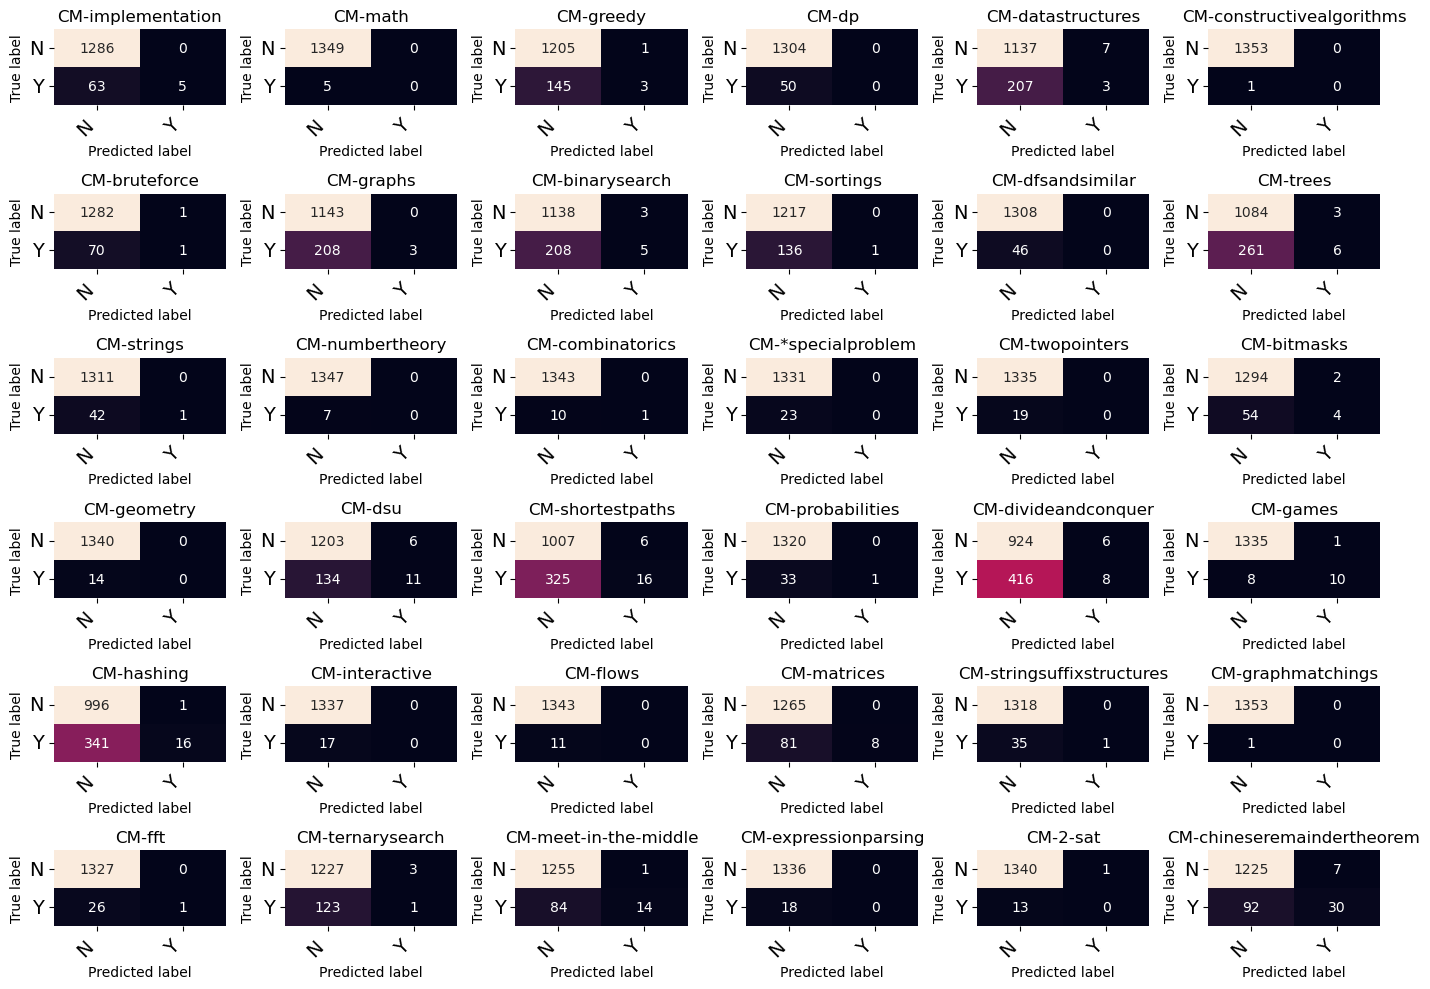

In [43]:
#Random forest Classifier

labels=total_tags.astype(str).values.tolist()
cfs_matrix=multilabel_confusion_matrix(y_test, rfc_predictions)
fig, ax = plt.subplots(6, 6, figsize=(14, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), cfs_matrix, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"]) 
fig.tight_layout()
plt.show()

#### Bi-LSTM model for multi-label classification

In [44]:
#Tokenize the x_train values
title_encoder = Tokenizer(oov_token="<ukn>")
title_encoder.fit_on_texts(X_train['problem_statement'].values)
train_titles = title_encoder.texts_to_sequences(X_train['problem_statement'].values)
test_titles = title_encoder.texts_to_sequences(X_test['problem_statement'].values)

In [45]:
len(title_encoder.word_index)

28234

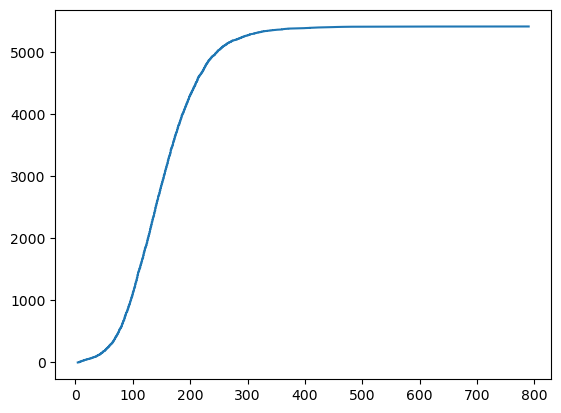

In [46]:
lens = [len(x) for x in train_titles]
plt.plot(sorted(lens), list(range(len(lens))))

We can see a peak at 250 so we set as padding length.

In [47]:
train_titles = pad_sequences(train_titles,maxlen=250)
test_titles = pad_sequences(test_titles,maxlen=250)

In [48]:
# get the model
def get_model(n_inputs, n_outputs):

    bilstm = tf.keras.Sequential()
    bilstm.add(tf.keras.layers.Embedding(input_dim = 28234+1,output_dim = 100,input_length=250))
    bilstm.add(tf.keras.layers.Bidirectional(LSTM(256, dropout=0.2,return_sequences=False)))
    bilstm.add(tf.keras.layers.Dense(256,input_dim=n_inputs, activation='relu'))
    bilstm.add(tf.keras.layers.Dense(37, activation='sigmoid'))
    bilstm.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    return bilstm

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y,n_input,n_output):
    results=list()
    model = get_model(n_input, n_output)
    model.fit(X, y, verbose=0, epochs=100, batch_size=10)
    yhat=model.predict(test_titles)
    return yhat


n_input=x_train_multilabel.shape[1]
n_output=y_train.shape[1]
train_x = x_train_multilabel.toarray()
train_y = y_train.toarray()
validation_x = x_test_multilabel.toarray()
validation_y = y_test.toarray()



# evaluate model
yhat=evaluate_model(train_titles, y_train.toarray(),n_input,n_output)
yhat[yhat>0.5] = 1
yhat[yhat<=0.5] = 0
print(metrics.classification_report(y_test, yhat))

43/43 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.34      0.21      0.26        68
           1       0.00      0.00      0.00         5
           2       0.25      0.18      0.21       148
           3       0.09      0.08      0.08        50
           4       0.16      0.23      0.19       210
           5       0.00      0.00      0.00         1
           6       0.33      0.30      0.31        71
           7       0.34      0.32      0.33       211
           8       0.34      0.36      0.35       213
           9       0.40      0.27      0.32       137
          10       0.08      0.02      0.03        46
          11       0.29      0.38      0.33       267
          12       0.21      0.12      0.15        43
          13       0.00      0.00      0.00         7
          14       0.33      0.09      0.14        11
          15       0.00      0.00      0.00        23
          16       0.37    

In [49]:
print("Accuracy of the Bilstm is:",metrics.accuracy_score(y_test, yhat))
print("Hamming loss of the Bilstm is",metrics.hamming_loss(y_test,yhat))

precision_bilstm = precision_score(y_test, yhat, average='micro')
recall_bilstm = recall_score(y_test, yhat, average='micro')
f1_bisltm = f1_score(y_test, yhat, average='micro')
hamming_bilstm=metrics.hamming_loss(y_test,yhat)
 
print("Micro-average scores")
print("Precision are : {:.4f}, Recall are : {:.4f}, F1-measure are : {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, yhat, average='macro')
recall = recall_score(y_test, yhat, average='macro')
f1 = f1_score(y_test, yhat, average='macro')
 
print("Macro-average scores")
print("Precision are : {:.4f}, Recall are: {:.4f}, F1-measure are: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, yhat))

Accuracy of the Bilstm is: 0.04062038404726736
Hamming loss of the Bilstm is 0.09235897640624376
Micro-average scores
Precision are : 0.3782, Recall are : 0.2308, F1-measure are : 0.2713
Macro-average scores
Precision are : 0.2442, Recall are: 0.2026, F1-measure are: 0.2168
              precision    recall  f1-score   support

           0       0.34      0.21      0.26        68
           1       0.00      0.00      0.00         5
           2       0.25      0.18      0.21       148
           3       0.09      0.08      0.08        50
           4       0.16      0.23      0.19       210
           5       0.00      0.00      0.00         1
           6       0.33      0.30      0.31        71
           7       0.34      0.32      0.33       211
           8       0.34      0.36      0.35       213
           9       0.40      0.27      0.32       137
          10       0.08      0.02      0.03        46
          11       0.29      0.38      0.33       267
          12       0.2

In [50]:
print("Performance comparison of Models\n")
d = [[1,"Logistic-Regression", round(precision_score(y_test, predictions, average='micro'),3), round(recall_score(y_test, predictions, average='micro'),3),round(f1_score(y_test, predictions, average='micro'),3),round(metrics.hamming_loss(y_test,predictions),3)],
 [2,"Random Forest Classifier", round(precision_rf ,3), round(recall_rf ,3),round(f1_rf,3),round(rf_hamming_loss,3)],
 [3,"Bidirectional-lstm",round(precision_bilstm ,3),round(recall_bilstm ,3),round(f1_bisltm ,3),round(hamming_bilstm,3)],
 [4,"SVM Classifier",round(precision_score(y_test, predictions_sdg, average='micro'),3), round(recall_score(y_test, predictions_sdg, average='micro'),3),round(f1_score(y_test, predictions_sdg, average='micro'),3),round(metrics.hamming_loss(y_test,predictions_sdg),3)]]

print(tabulate(d, headers=['Sl-no','Algorithm','Precision','Recall','Micro-f1score','Hamming-loss']))

Performance comparison of Models

  Sl-no  Algorithm                   Precision    Recall    Micro-f1score    Hamming-loss
-------  ------------------------  -----------  --------  ---------------  --------------
      1  Logistic-Regression             0.536     0.295            0.381           0.068
      2  Random Forest Classifier        0.743     0.042            0.08            0.069
      3  Bidirectional-lstm              0.337     0.315            0.325           0.092
      4  SVM Classifier                  0.469     0.325            0.384           0.074
